# Taller 1

# Parte 1: Regresión con redes neuronales

Importación de librerías y carga de datos

In [131]:

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.nn.functional import one_hot
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.utils import resample


In [132]:
# Cargar datos
df = pd.read_csv('auto-mpg.data',
                 names=['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin'],
                 sep=' ',
                 na_values='?',
                 comment='\t',
                 skipinitialspace=True
                 )

# Explorar datos
print("Forma del dataset:", df.shape)
print("\nPrimeras filas:")
df.head()

Forma del dataset: (398, 8)

Primeras filas:


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [133]:
# Verificar y Eliminar valores faltantes
print("Valores faltantes por columna:")
print(df.isna().sum())

df.dropna(inplace=True)
df = df.reset_index(drop=True)
print(f"\nForma después de eliminar NAs: {df.shape}")

Valores faltantes por columna:
MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

Forma después de eliminar NAs: (392, 8)


In [134]:
# Dividir datos en entrenamiento y prueba
train, test = model_selection.train_test_split(df, train_size=0.8, random_state=100)
print(f"Datos de entrenamiento: {train.shape}")
print(f"Datos de prueba: {test.shape}")

Datos de entrenamiento: (313, 8)
Datos de prueba: (79, 8)


## 1. Modelo con una sola variable predictora y capa lineal

Utilizaremos solo la variable Weight como predictor

In [135]:
# Preparar datos para modelo univariado (solo Weight)
def prepare_single_variable_data(train_df, test_df, variable='Weight'):
    """
    Prepara los datos para un modelo con una sola variable predictora
    """
    # Normalizar la variable predictora
    mean_var = train_df[variable].mean()
    std_var = train_df[variable].std()
    
    # Normalizar variable de entrada
    x_train_single = torch.tensor((train_df[variable].values - mean_var) / std_var).float().reshape(-1, 1)
    x_test_single = torch.tensor((test_df[variable].values - mean_var) / std_var).float().reshape(-1, 1)
    
    # Variable objetivo (sin normalizar para interpretabilidad)
    y_train_single = torch.tensor(train_df['MPG'].values).float()
    y_test_single = torch.tensor(test_df['MPG'].values).float()
    
    return x_train_single, x_test_single, y_train_single, y_test_single

x_train_single, x_test_single, y_train_single, y_test_single = prepare_single_variable_data(train, test, 'Weight')

print(f"Forma de X_train: {x_train_single.shape}")
print(f"Forma de y_train: {y_train_single.shape}")

Forma de X_train: torch.Size([313, 1])
Forma de y_train: torch.Size([313])


In [136]:
# Modelo base: una sola capa lineal
class LinearModel(nn.Module):
    def __init__(self, input_size=1):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)
    
    def forward(self, x):
        return self.linear(x)

# Crear modelo base
model_base = LinearModel(input_size=1)
print("Modelo base:")
print(model_base)

Modelo base:
LinearModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)


In [137]:
# Función de entrenamiento
def train_model(model, x_train, y_train, epochs=1000, lr=0.01, batch_size=16):
    """
    Entrena un modelo y retorna el historial de pérdidas
    """
    # Dataset y DataLoader
    train_ds = TensorDataset(x_train, y_train)
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    
    # Configurar optimizador y función de pérdida
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    
    # Historial de pérdidas
    loss_history = []
    
    # Entrenamiento
    torch.manual_seed(42)
    for epoch in range(epochs):
        epoch_loss = 0
        for x_batch, y_batch in train_dl:
            # Forward pass
            pred = model(x_batch).squeeze()
            loss = loss_fn(pred, y_batch)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(train_dl)
        loss_history.append(avg_loss)
        
        if (epoch + 1) % 200 == 0:
            print(f'Época {epoch+1}/{epochs}, Pérdida: {avg_loss:.4f}')
    
    return loss_history

# Entrenar modelo base
print("Entrenando modelo base (capa lineal)...")
loss_history_base = train_model(model_base, x_train_single, y_train_single, epochs=1000, lr=0.01)

Entrenando modelo base (capa lineal)...
Época 200/1000, Pérdida: 20.0252
Época 400/1000, Pérdida: 19.9613
Época 600/1000, Pérdida: 20.0593
Época 800/1000, Pérdida: 20.3789
Época 1000/1000, Pérdida: 19.9474


## 2. Evaluación del modelo base


In [138]:
# Función de evaluación
def evaluate_model(model, x_test, y_test):
    """
    Evalúa un modelo usando MSE y MAE
    """
    model.eval()
    with torch.no_grad():
        pred = model(x_test).squeeze()
        mse = nn.MSELoss()(pred, y_test).item()
        mae = nn.L1Loss()(pred, y_test).item()
    return mse, mae, pred

# Evaluar modelo base
mse_base, mae_base, pred_base = evaluate_model(model_base, x_test_single, y_test_single)
print(f"Modelo Base - MSE: {mse_base:.4f}, MAE: {mae_base:.4f}")

Modelo Base - MSE: 13.2565, MAE: 2.8184


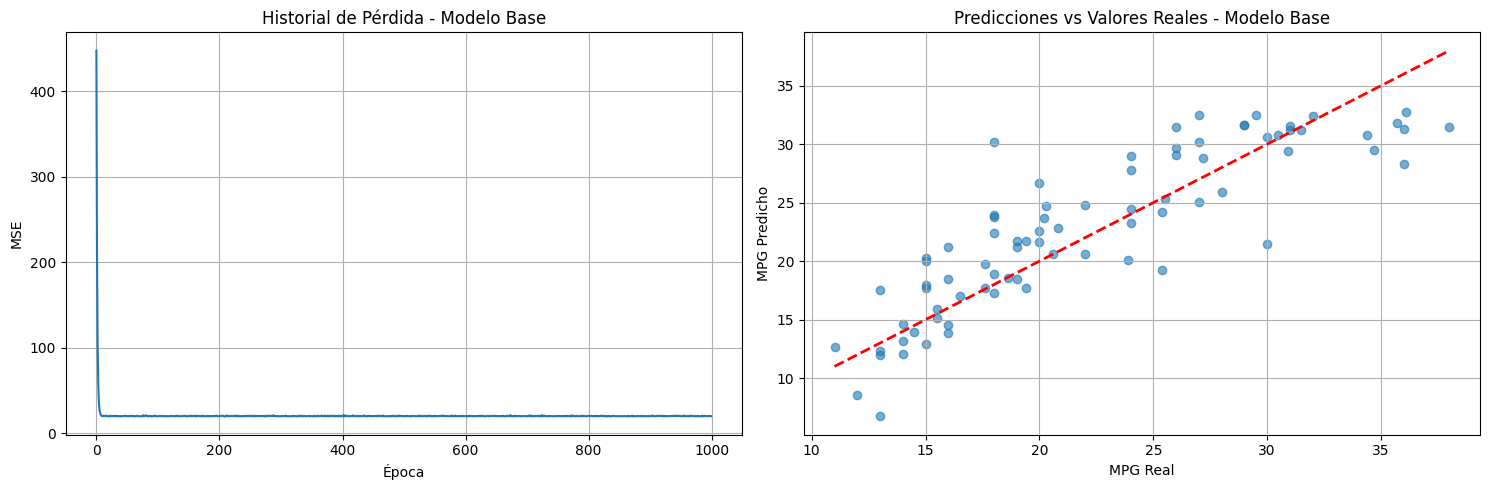

In [139]:
# Graficar historial de pérdida y resultados
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Historial de pérdida
axes[0].plot(loss_history_base)
axes[0].set_title('Historial de Pérdida - Modelo Base')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('MSE')
axes[0].grid(True)

# Predicciones vs valores reales
axes[1].scatter(y_test_single.numpy(), pred_base.numpy(), alpha=0.6)
axes[1].plot([y_test_single.min(), y_test_single.max()], 
             [y_test_single.min(), y_test_single.max()], 'r--', lw=2)
axes[1].set_xlabel('MPG Real')
axes[1].set_ylabel('MPG Predicho')
axes[1].set_title('Predicciones vs Valores Reales - Modelo Base')
axes[1].grid(True)

plt.tight_layout()
plt.show()

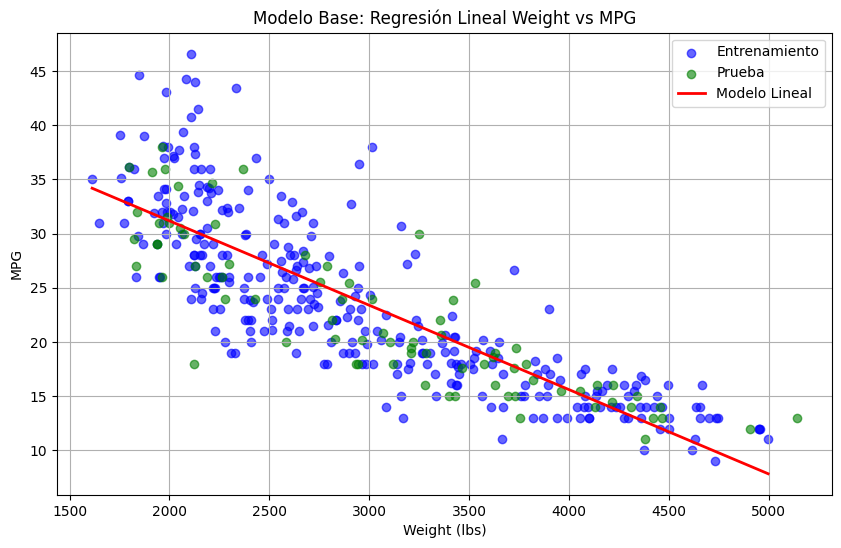

In [140]:
# Visualizar la función aprendida
plt.figure(figsize=(10, 6))

# Datos de entrenamiento
weight_train_orig = train['Weight'].values
mpg_train = train['MPG'].values

# Datos de prueba
weight_test_orig = test['Weight'].values
mpg_test = test['MPG'].values

# Crear rango para visualizar la función
weight_range = np.linspace(weight_train_orig.min(), weight_train_orig.max(), 100)
weight_range_norm = (weight_range - train['Weight'].mean()) / train['Weight'].std()
weight_range_tensor = torch.tensor(weight_range_norm).float().reshape(-1, 1)

# Predicciones para el rango
with torch.no_grad():
    pred_range = model_base(weight_range_tensor).squeeze().numpy()

# Graficar
plt.scatter(weight_train_orig, mpg_train, alpha=0.6, label='Entrenamiento', color='blue')
plt.scatter(weight_test_orig, mpg_test, alpha=0.6, label='Prueba', color='green')
plt.plot(weight_range, pred_range, 'r-', linewidth=2, label='Modelo Lineal')
plt.xlabel('Weight (lbs)')
plt.ylabel('MPG')
plt.title('Modelo Base: Regresión Lineal Weight vs MPG')
plt.legend()
plt.grid(True)
plt.show()

Comentarios sobre el modelo base: 

El modelo base utiliza una regresión lineal simple con la variable Weight
La relación lineal captura la tendencia negativa entre peso y eficiencia de combustible

El MSE es de 13.25 y MAE 2.818 esta un poco grande, de igual forma se tiene que comparara para decidir cual modelo 

## 3. Modelo con función de activación no lineal


In [141]:
# Modelo con activación no lineal
class NonLinearModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=10):
        super(NonLinearModel, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.activation = nn.ReLU()
        self.output = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        x = self.hidden(x)
        x = self.activation(x)
        x = self.output(x)
        return x

# Crear y entrenar modelo no lineal
model_nonlinear = NonLinearModel(input_size=1, hidden_size=10)
print("Modelo no lineal:")
print(model_nonlinear)

print("\nEntrenando modelo no lineal...")
loss_history_nonlinear = train_model(model_nonlinear, x_train_single, y_train_single, epochs=1000, lr=0.01)

Modelo no lineal:
NonLinearModel(
  (hidden): Linear(in_features=1, out_features=10, bias=True)
  (activation): ReLU()
  (output): Linear(in_features=10, out_features=1, bias=True)
)

Entrenando modelo no lineal...
Época 200/1000, Pérdida: 18.4893
Época 400/1000, Pérdida: 18.9170
Época 600/1000, Pérdida: 20.2528
Época 800/1000, Pérdida: 19.2539
Época 1000/1000, Pérdida: 19.5469


In [142]:
# Evaluar modelo no lineal
mse_nonlinear, mae_nonlinear, pred_nonlinear = evaluate_model(model_nonlinear, x_test_single, y_test_single)
print(f"Modelo No Lineal - MSE: {mse_nonlinear:.4f}, MAE: {mae_nonlinear:.4f}")

# Comparación con modelo base
print(f"\nComparación:")
print(f"Modelo Base     - MSE: {mse_base:.4f}, MAE: {mae_base:.4f}")
print(f"Modelo No Lineal - MSE: {mse_nonlinear:.4f}, MAE: {mae_nonlinear:.4f}")
print(f"Mejora en MSE: {((mse_base - mse_nonlinear) / mse_base * 100):.2f}%")

Modelo No Lineal - MSE: 11.7856, MAE: 2.5160

Comparación:
Modelo Base     - MSE: 13.2565, MAE: 2.8184
Modelo No Lineal - MSE: 11.7856, MAE: 2.5160
Mejora en MSE: 11.10%


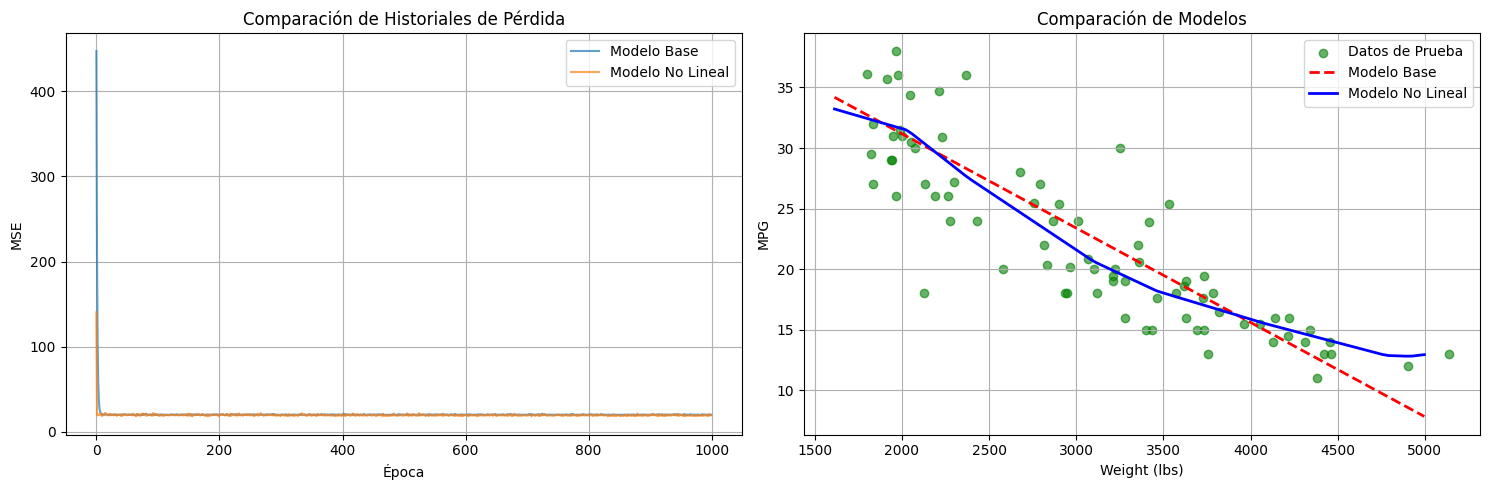

In [143]:
# Visualizar comparación
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Historial de pérdidas
axes[0].plot(loss_history_base, label='Modelo Base', alpha=0.7)
axes[0].plot(loss_history_nonlinear, label='Modelo No Lineal', alpha=0.7)
axes[0].set_title('Comparación de Historiales de Pérdida')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('MSE')
axes[0].legend()
axes[0].grid(True)

# Funciones aprendidas
weight_range = np.linspace(weight_train_orig.min(), weight_train_orig.max(), 100)
weight_range_norm = (weight_range - train['Weight'].mean()) / train['Weight'].std()
weight_range_tensor = torch.tensor(weight_range_norm).float().reshape(-1, 1)

with torch.no_grad():
    pred_range_base = model_base(weight_range_tensor).squeeze().numpy()
    pred_range_nonlinear = model_nonlinear(weight_range_tensor).squeeze().numpy()

axes[1].scatter(weight_test_orig, mpg_test, alpha=0.6, label='Datos de Prueba', color='green')
axes[1].plot(weight_range, pred_range_base, 'r--', linewidth=2, label='Modelo Base')
axes[1].plot(weight_range, pred_range_nonlinear, 'b-', linewidth=2, label='Modelo No Lineal')
axes[1].set_xlabel('Weight (lbs)')
axes[1].set_ylabel('MPG')
axes[1].set_title('Comparación de Modelos')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

Comentarios sobre el modelo no lineal:

El modelo usa la funcion de activación ReLU para capturar relaciones no lineales en los datos

El modelo mejora la prediccion con respecto al modelo lineal.

## 4. Modelo con múltiples capas

In [144]:
# Modelo con múltiples capas
class DeepModel(nn.Module):
    def __init__(self, input_size=1, hidden_sizes=[20, 10, 5]):
        super(DeepModel, self).__init__()
        layers = []
        
        # Primera capa
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.ReLU())
        
        # Capas ocultas
        for i in range(len(hidden_sizes) - 1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            layers.append(nn.ReLU())
        
        # Capa de salida
        layers.append(nn.Linear(hidden_sizes[-1], 1))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

# Crear y entrenar modelo profundo
model_deep = DeepModel(input_size=1, hidden_sizes=[20, 10, 5])
print("Modelo profundo:")
print(model_deep)

print("\nEntrenando modelo profundo...")
loss_history_deep = train_model(model_deep, x_train_single, y_train_single, epochs=1500, lr=0.005)

Modelo profundo:
DeepModel(
  (network): Sequential(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=5, bias=True)
    (5): ReLU()
    (6): Linear(in_features=5, out_features=1, bias=True)
  )
)

Entrenando modelo profundo...


Época 200/1500, Pérdida: 17.8497
Época 400/1500, Pérdida: 18.2006
Época 600/1500, Pérdida: 19.6003
Época 800/1500, Pérdida: 18.5316
Época 1000/1500, Pérdida: 18.7365
Época 1200/1500, Pérdida: 18.7885
Época 1400/1500, Pérdida: 17.9909


In [145]:
# Evaluar modelo profundo
mse_deep, mae_deep, pred_deep = evaluate_model(model_deep, x_test_single, y_test_single)

# Comparación de todos los modelos
print("Comparación de todos los modelos:")
print(f"Modelo Base       - MSE: {mse_base:.4f}, MAE: {mae_base:.4f}")
print(f"Modelo No Lineal  - MSE: {mse_nonlinear:.4f}, MAE: {mae_nonlinear:.4f}")
print(f"Modelo Profundo   - MSE: {mse_deep:.4f}, MAE: {mae_deep:.4f}")

Comparación de todos los modelos:
Modelo Base       - MSE: 13.2565, MAE: 2.8184
Modelo No Lineal  - MSE: 11.7856, MAE: 2.5160
Modelo Profundo   - MSE: 15.6408, MAE: 2.8581


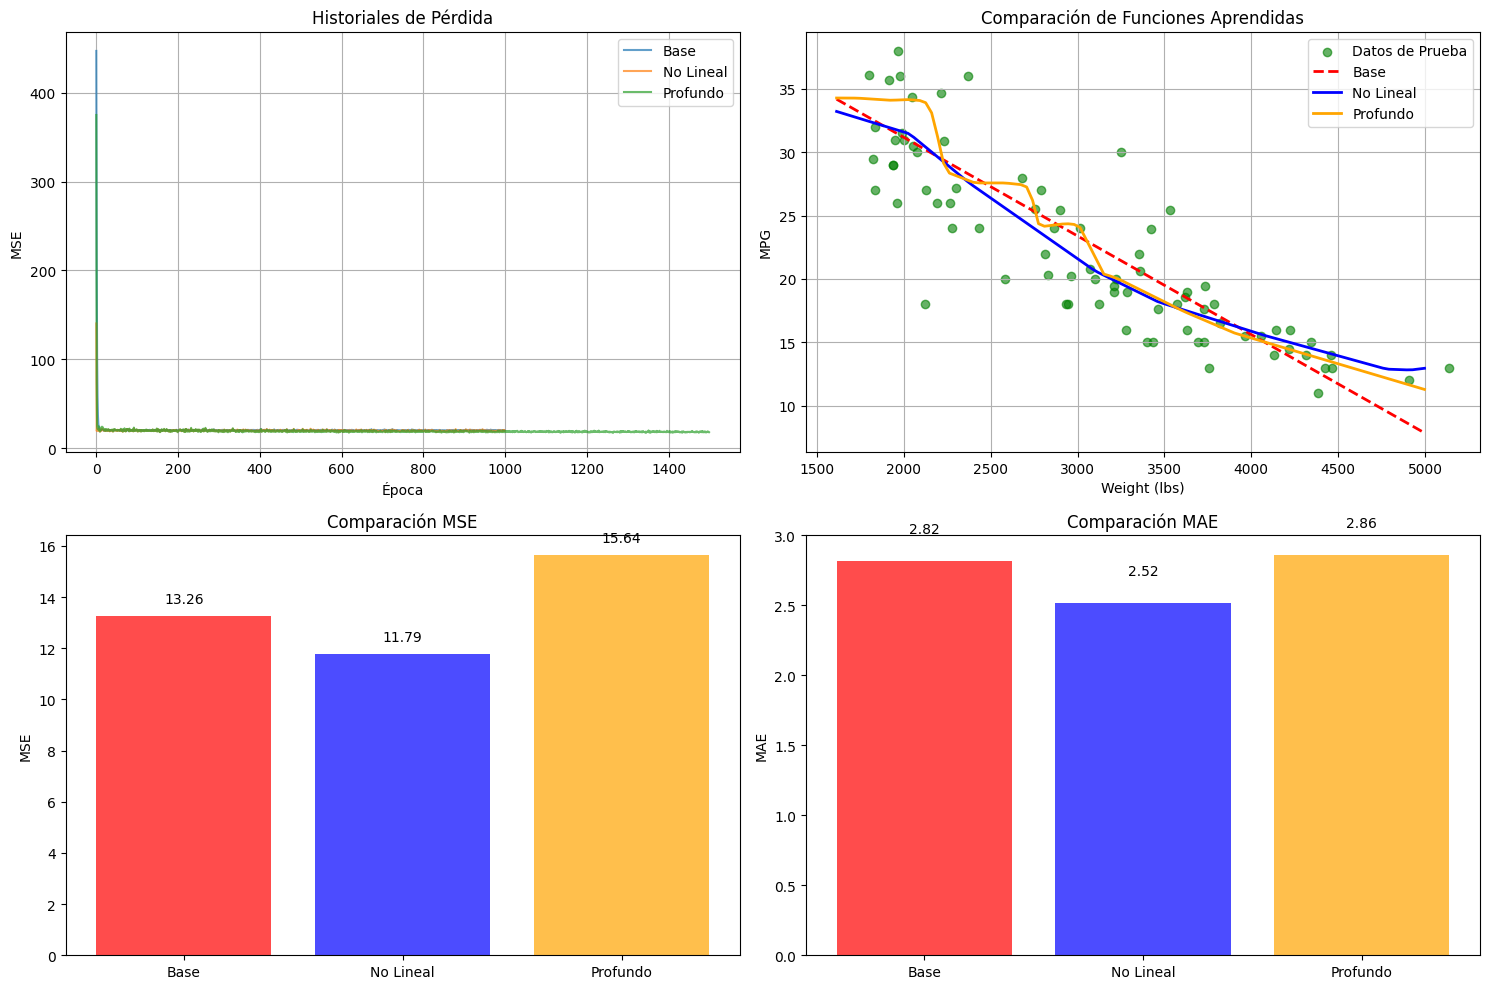

In [146]:
# Visualización comparativa final
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Historiales de pérdida
axes[0,0].plot(loss_history_base, label='Base', alpha=0.7)
axes[0,0].plot(loss_history_nonlinear, label='No Lineal', alpha=0.7)
axes[0,0].plot(loss_history_deep, label='Profundo', alpha=0.7)
axes[0,0].set_title('Historiales de Pérdida')
axes[0,0].set_xlabel('Época')
axes[0,0].set_ylabel('MSE')
axes[0,0].legend()
axes[0,0].grid(True)

# Funciones aprendidas
with torch.no_grad():
    pred_range_deep = model_deep(weight_range_tensor).squeeze().numpy()

axes[0,1].scatter(weight_test_orig, mpg_test, alpha=0.6, label='Datos de Prueba', color='green')
axes[0,1].plot(weight_range, pred_range_base, 'r--', linewidth=2, label='Base')
axes[0,1].plot(weight_range, pred_range_nonlinear, 'b-', linewidth=2, label='No Lineal')
axes[0,1].plot(weight_range, pred_range_deep, 'orange', linewidth=2, label='Profundo')
axes[0,1].set_xlabel('Weight (lbs)')
axes[0,1].set_ylabel('MPG')
axes[0,1].set_title('Comparación de Funciones Aprendidas')
axes[0,1].legend()
axes[0,1].grid(True)

# Métricas de comparación
models = ['Base', 'No Lineal', 'Profundo']
mse_values = [mse_base, mse_nonlinear, mse_deep]
mae_values = [mae_base, mae_nonlinear, mae_deep]

axes[1,0].bar(models, mse_values, alpha=0.7, color=['red', 'blue', 'orange'])
axes[1,0].set_title('Comparación MSE')
axes[1,0].set_ylabel('MSE')
for i, v in enumerate(mse_values):
    axes[1,0].text(i, v + 0.5, f'{v:.2f}', ha='center')

axes[1,1].bar(models, mae_values, alpha=0.7, color=['red', 'blue', 'orange'])
axes[1,1].set_title('Comparación MAE')
axes[1,1].set_ylabel('MAE')
for i, v in enumerate(mae_values):
    axes[1,1].text(i, v + 0.2, f'{v:.2f}', ha='center')

plt.tight_layout()
plt.show()

Comentarios sobre modelos con múltiples capas:

Se realizo con tres capas de 20 10 5 neuranas respectivamnete.

con esas capas y con ReLU se dio un pequeño overfiting que llevo a que el modelo no prediga de la mejor manera.Obteniendo un mse mayor al entrenado con una sola capa.

# Parte 2: Clasificación con redes neuronales

Carga y exploración de datos de enfermedad cardíaca


In [147]:
# Cargar datos de enfermedad cardíaca
heart_df = pd.read_csv('heart.csv')

print("Forma del dataset:", heart_df.shape)
print("\nPrimeras filas:")
heart_df.head()

Forma del dataset: (303, 14)

Primeras filas:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


In [148]:
# Exploración de datos
print("Información del dataset:")
print(heart_df.info())
print("\nEstadísticas descriptivas:")
print(heart_df.describe())
print("\nDistribución de la variable objetivo:")
print(heart_df['target'].value_counts())

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    object 
 13  target    303 non-null    int64  
dtypes: float64(1), int64(12), object(1)
memory usage: 33.3+ KB
None

Estadísticas descriptivas:
              age         sex          cp    trestbps        chol         fbs  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  3

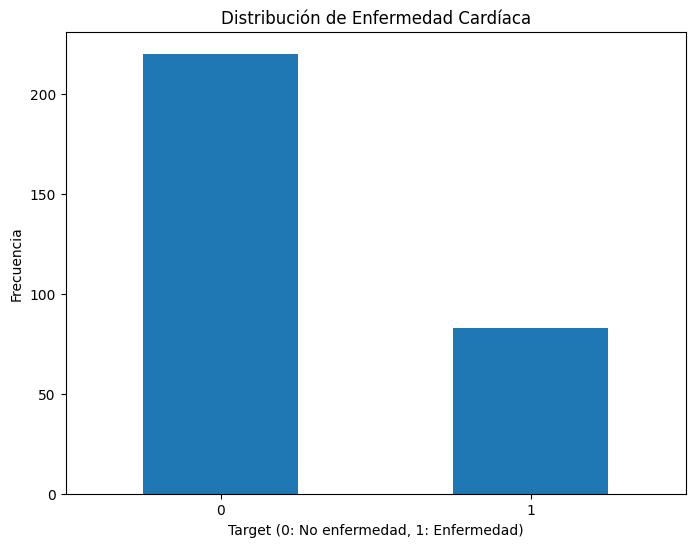

In [149]:
# Visualización de la distribución de la variable objetivo
plt.figure(figsize=(8, 6))
heart_df['target'].value_counts().plot(kind='bar')
plt.title('Distribución de Enfermedad Cardíaca')
plt.xlabel('Target (0: No enfermedad, 1: Enfermedad)')
plt.ylabel('Frecuencia')
plt.xticks(rotation=0)
plt.show()


## 1. Preparación de datos para clasificación y Modelo base de clasificación

In [150]:
# Preprocesamiento de variables categóricas
heart_df_processed = heart_df.copy()

# Codificar la variable categórica 'thal' usando Label Encoding
le_thal = LabelEncoder()
heart_df_processed['thal'] = le_thal.fit_transform(heart_df_processed['thal'])

print("Valores únicos en 'thal' después de codificación:")
print(heart_df_processed['thal'].value_counts())
print("\nMapping de 'thal':")
for i, label in enumerate(le_thal.classes_):
    print(f"{label} -> {i}")

Valores únicos en 'thal' después de codificación:
thal
3    168
4    115
2     18
0      1
1      1
Name: count, dtype: int64

Mapping de 'thal':
1 -> 0
2 -> 1
fixed -> 2
normal -> 3
reversible -> 4


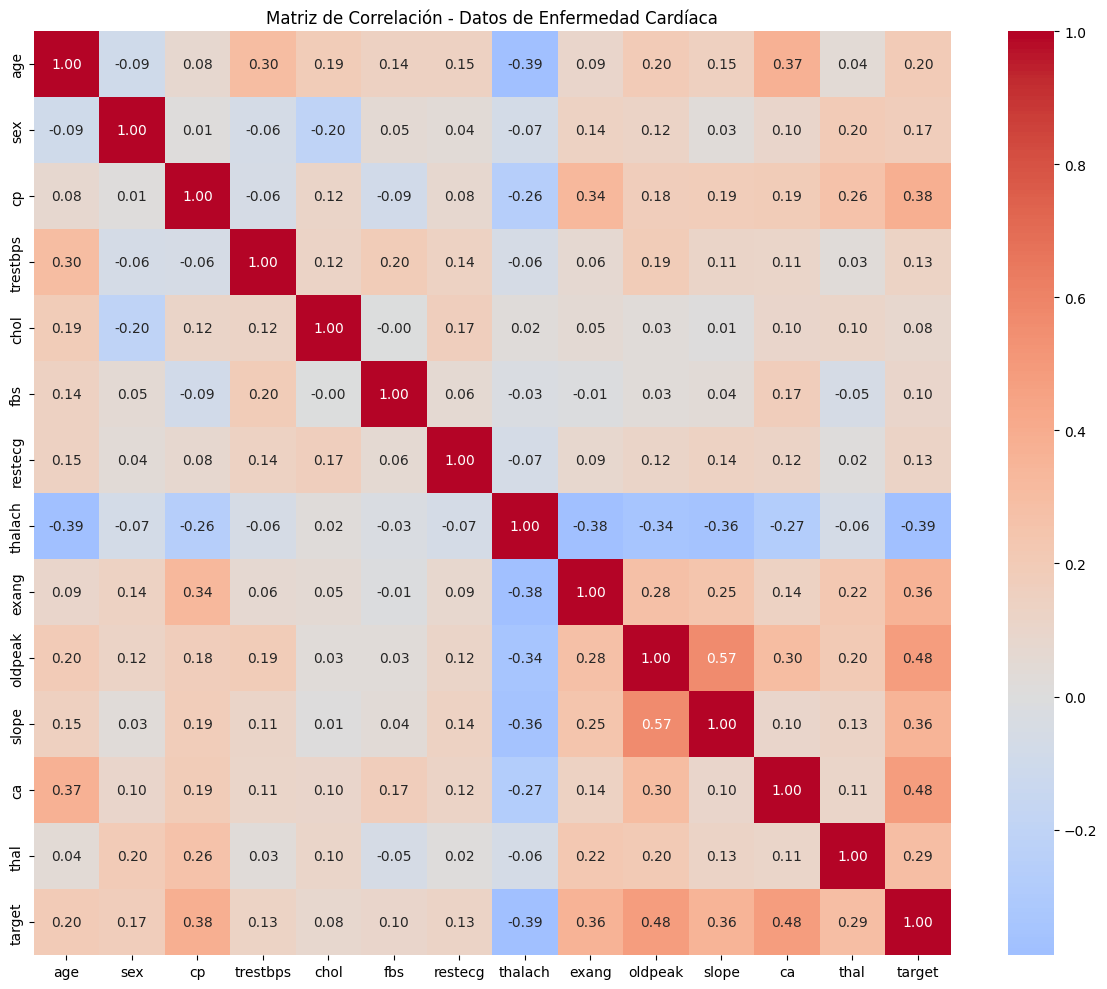

In [151]:
# Matriz de correlación con datos procesados
plt.figure(figsize=(12, 10))
sns.heatmap(heart_df_processed.corr(), annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Matriz de Correlación - Datos de Enfermedad Cardíaca')
plt.tight_layout()
plt.show()

In [152]:
# Dividir datos en entrenamiento y prueba
heart_train, heart_test = model_selection.train_test_split(heart_df_processed, train_size=0.8, random_state=42)

print(f"Datos de entrenamiento: {heart_train.shape}")
print(f"Datos de prueba: {heart_test.shape}")

# Separar características y variable objetivo
feature_cols = [col for col in heart_df_processed.columns if col != 'target']
print(f"Características: {feature_cols}")

Datos de entrenamiento: (242, 14)
Datos de prueba: (61, 14)
Características: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']


Normalizar y solucion desbalance de clases con oversampling (SMOTE), para evitar quedarnos sin datos, dado que la cantidad de target en 1 es de 14 que son muy pocos datos para hacer undersample

In [153]:
# Normalizar características
def normalize_features(train_df, test_df, feature_columns):
    train_norm = train_df.copy()
    test_norm = test_df.copy()
    
    for col in feature_columns:
        mean_val = train_df[col].mean()
        std_val = train_df[col].std()
        
        # Evitar división por cero
        if std_val == 0:
            std_val = 1
        
        train_norm[col] = (train_df[col] - mean_val) / std_val
        test_norm[col] = (test_df[col] - mean_val) / std_val
    
    return train_norm, test_norm

heart_train_norm, heart_test_norm = normalize_features(heart_train, heart_test, feature_cols)


# Verificar distribución antes del oversampling
print("Distribución ANTES del oversampling:")
print(heart_train_norm['target'].value_counts())
print(f"Proporción clase 0: {(heart_train_norm['target'] == 0).sum() / len(heart_train_norm):.3f}")
print(f"Proporción clase 1: {(heart_train_norm['target'] == 1).sum() / len(heart_train_norm):.3f}")

# Separar por clases
class_0 = heart_train_norm[heart_train_norm['target'] == 0]
class_1 = heart_train_norm[heart_train_norm['target'] == 1]

print(f"\nClase 0 (sin enfermedad): {len(class_0)} muestras")
print(f"Clase 1 (con enfermedad): {len(class_1)} muestras")

# Hacer oversampling de la clase minoritaria (clase 1)
# Usar el número de muestras de la clase mayoritaria como objetivo
n_majority = len(class_0)

class_1_oversampled = resample(class_1, 
                               replace=True,           # permitir duplicados
                               n_samples=n_majority,   # igualar a la clase mayoritaria
                               random_state=42)        # para reproducibilidad

# Combinar las clases balanceadas
heart_train_balanced = pd.concat([class_0, class_1_oversampled])

# Mezclar los datos para evitar que estén ordenados por clase
heart_train_balanced = heart_train_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# IMPORTANTE: Reemplazar heart_train_norm con los datos balanceados
# Esto mantiene el mismo nombre de variable para el resto del código
heart_train_norm = heart_train_balanced

print(f"\nDistribución DESPUÉS del oversampling:")
print(heart_train_norm['target'].value_counts())
print(f"Proporción clase 0: {(heart_train_norm['target'] == 0).sum() / len(heart_train_norm):.3f}")
print(f"Proporción clase 1: {(heart_train_norm['target'] == 1).sum() / len(heart_train_norm):.3f}")

print(f"\nNuevo tamaño de datos de entrenamiento: {heart_train_norm.shape}")
print(f"Datos de prueba (sin cambios): {heart_test_norm.shape}")




# Convertir a tensores
x_train_heart = torch.tensor(heart_train_norm[feature_cols].values, dtype=torch.float32)
y_train_heart = torch.tensor(heart_train_norm['target'].values, dtype=torch.float32)
x_test_heart = torch.tensor(heart_test_norm[feature_cols].values, dtype=torch.float32)
y_test_heart = torch.tensor(heart_test_norm['target'].values, dtype=torch.float32)

print(f"Forma de X_train: {x_train_heart.shape}")
print(f"Forma de y_train: {y_train_heart.shape}")
print(f"Forma de X_test: {x_test_heart.shape}")
print(f"Forma de y_test: {y_test_heart.shape}")

Distribución ANTES del oversampling:
target
0    176
1     66
Name: count, dtype: int64
Proporción clase 0: 0.727
Proporción clase 1: 0.273

Clase 0 (sin enfermedad): 176 muestras
Clase 1 (con enfermedad): 66 muestras

Distribución DESPUÉS del oversampling:
target
1    176
0    176
Name: count, dtype: int64
Proporción clase 0: 0.500
Proporción clase 1: 0.500

Nuevo tamaño de datos de entrenamiento: (352, 14)
Datos de prueba (sin cambios): (61, 14)
Forma de X_train: torch.Size([352, 13])
Forma de y_train: torch.Size([352])
Forma de X_test: torch.Size([61, 13])
Forma de y_test: torch.Size([61])


In [154]:
# Modelo base para clasificación
class HeartDiseaseClassifier(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super(HeartDiseaseClassifier, self).__init__()
        self.hidden1 = nn.Linear(input_size, hidden_size)
        self.hidden2 = nn.Linear(hidden_size, 32)
        self.output = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = self.relu(self.hidden1(x))
        x = self.dropout(x)
        x = self.relu(self.hidden2(x))
        x = self.dropout(x)
        x = self.sigmoid(self.output(x))
        return x

# Crear modelo base
input_size = x_train_heart.shape[1]
model_heart_base = HeartDiseaseClassifier(input_size, hidden_size=64)
print("Modelo base de clasificación:")
print(model_heart_base)
print(f"Número de parámetros: {sum(p.numel() for p in model_heart_base.parameters())}")

Modelo base de clasificación:
HeartDiseaseClassifier(
  (hidden1): Linear(in_features=13, out_features=64, bias=True)
  (hidden2): Linear(in_features=64, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.2, inplace=False)
)
Número de parámetros: 3009


## 2. Entrenamiento y Evaluacion del modelo base de clasificación

In [155]:
# Función de entrenamiento para clasificación
def train_classifier(model, x_train, y_train, epochs=500, lr=0.001, batch_size=32):
    # Dataset y DataLoader
    train_ds = TensorDataset(x_train, y_train)
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    
    # Configurar optimizador y función de pérdida
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.BCELoss()  # Binary Cross Entropy para clasificación binaria
    
    # Historial de pérdidas
    loss_history = []
    
    # Entrenamiento
    torch.manual_seed(42)
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for x_batch, y_batch in train_dl:
            # Forward pass
            pred = model(x_batch).squeeze()
            loss = loss_fn(pred, y_batch)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(train_dl)
        loss_history.append(avg_loss)
        
        if (epoch + 1) % 100 == 0:
            print(f'Época {epoch+1}/{epochs}, Pérdida: {avg_loss:.4f}')
    
    return loss_history

# Entrenar modelo base
print("Entrenando modelo base de clasificación...")
loss_history_heart_base = train_classifier(model_heart_base, x_train_heart, y_train_heart, epochs=500, lr=0.001)

Entrenando modelo base de clasificación...


Época 100/500, Pérdida: 0.0646
Época 200/500, Pérdida: 0.0163
Época 300/500, Pérdida: 0.0195
Época 400/500, Pérdida: 0.0069
Época 500/500, Pérdida: 0.0040


In [156]:
# Función de evaluación para clasificación
def evaluate_classifier(model, x_test, y_test):
    model.eval()
    with torch.no_grad():
        pred_prob = model(x_test).squeeze()
        pred_binary = (pred_prob > 0.5).float()
    
    # Convertir a numpy para métricas
    y_true = y_test.numpy()
    y_pred = pred_binary.numpy()
    y_prob = pred_prob.numpy()
    
    # Calcular métricas
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_prob)
    
    return accuracy, precision, recall, f1, auc, y_pred, y_prob

# Evaluar modelo base
acc_base, prec_base, rec_base, f1_base, auc_base, pred_base, prob_base = evaluate_classifier(model_heart_base, x_test_heart, y_test_heart)

print("Métricas del modelo base:")
print(f"Accuracy: {acc_base:.4f}")
print(f"Precision: {prec_base:.4f}")
print(f"Recall: {rec_base:.4f}")
print(f"F1-Score: {f1_base:.4f}")
print(f"AUC: {auc_base:.4f}")

Métricas del modelo base:
Accuracy: 0.7869
Precision: 0.6000
Recall: 0.7059
F1-Score: 0.6486
AUC: 0.8556


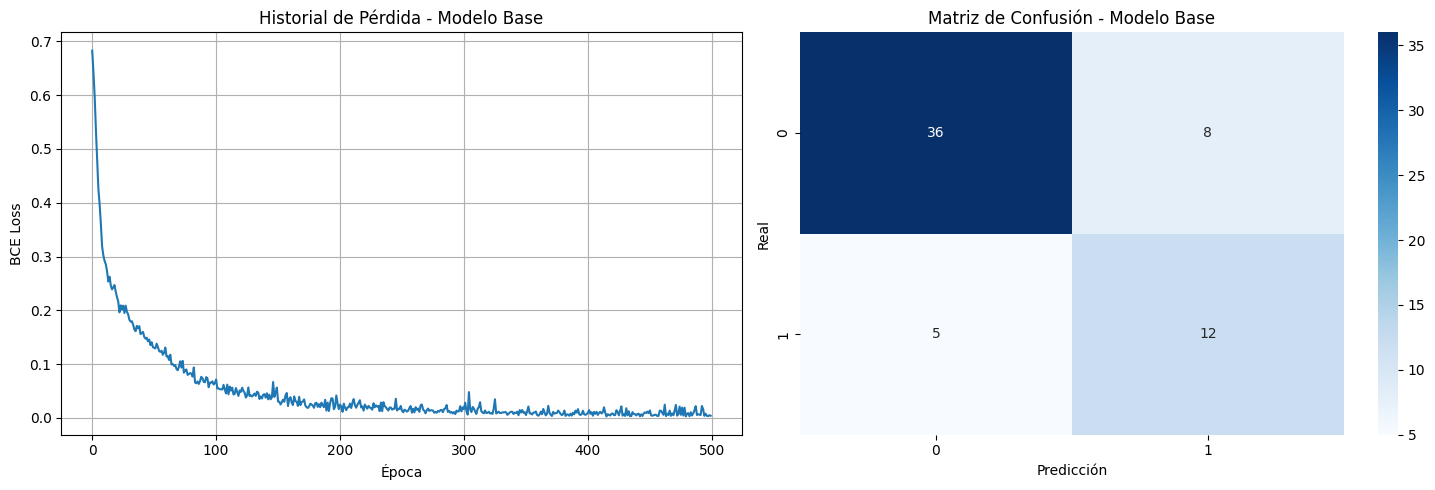

In [157]:
# Visualizar resultados del modelo base
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Historial de pérdida
axes[0].plot(loss_history_heart_base)
axes[0].set_title('Historial de Pérdida - Modelo Base')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('BCE Loss')
axes[0].grid(True)

# Matriz de confusión
cm = confusion_matrix(y_test_heart.numpy(), pred_base)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Matriz de Confusión - Modelo Base')
axes[1].set_xlabel('Predicción')
axes[1].set_ylabel('Real')

plt.tight_layout()
plt.show()

Comentarios sobre el modelo base de clasificación:

Utilizamos Label Encoding para la variable categórica thal, convirtiendo los valores de texto a números

La red neuronal tiene dos capas ocultas (64 y 32 neuronas) con dropout de 0.2 para regularización manteniendo la informacion, con la funcion de activacion ReLU para las capas ocultas.

La función de activación sigmoid en la salida es apropiada para clasificación binaria

La funcion de perdida es Binary Cross Entropy dado que estamos hablando de categoricas

Las métricas incluyen precisión, recall, F1-score y AUC para evaluación completa


## 3. Variación del número de neuronas


In [158]:
# Modelos con diferente número de neuronas
class HeartClassifierVariableNeurons(nn.Module):
    def __init__(self, input_size, hidden_sizes=[32, 16]):
        super(HeartClassifierVariableNeurons, self).__init__()
        layers = []
        
        prev_size = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2))
            prev_size = hidden_size
        
        layers.append(nn.Linear(prev_size, 1))
        layers.append(nn.Sigmoid())
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

# Caso 1: Menos neuronas
model_heart_small = HeartClassifierVariableNeurons(input_size, hidden_sizes=[32, 16])
print("Modelo con menos neuronas:")
print(model_heart_small)
print(f"Número de parámetros: {sum(p.numel() for p in model_heart_small.parameters())}")

print("\nEntrenando modelo con menos neuronas...")
loss_history_small = train_classifier(model_heart_small, x_train_heart, y_train_heart, epochs=500, lr=0.001)

# Caso 2: Más neuronas
model_heart_large = HeartClassifierVariableNeurons(input_size, hidden_sizes=[128, 64])
print("\nModelo con más neuronas:")
print(model_heart_large)
print(f"Número de parámetros: {sum(p.numel() for p in model_heart_large.parameters())}")

print("\nEntrenando modelo con más neuronas...")
loss_history_large = train_classifier(model_heart_large, x_train_heart, y_train_heart, epochs=500, lr=0.001)

Modelo con menos neuronas:
HeartClassifierVariableNeurons(
  (network): Sequential(
    (0): Linear(in_features=13, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
    (7): Sigmoid()
  )
)
Número de parámetros: 993

Entrenando modelo con menos neuronas...
Época 100/500, Pérdida: 0.1239
Época 200/500, Pérdida: 0.0575
Época 300/500, Pérdida: 0.0708
Época 400/500, Pérdida: 0.0262
Época 500/500, Pérdida: 0.0218

Modelo con más neuronas:
HeartClassifierVariableNeurons(
  (network): Sequential(
    (0): Linear(in_features=13, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
    (7

Comparación de modelos por número de neuronas:
Modelo Base (64,32)       - Acc: 0.7869, F1: 0.6486, AUC: 0.8556
Modelo Pequeño (32,16)    - Acc: 0.7869, F1: 0.6486, AUC: 0.8690
Modelo Grande (128,64) - Acc: 0.8033, F1: 0.6842, AUC: 0.8476


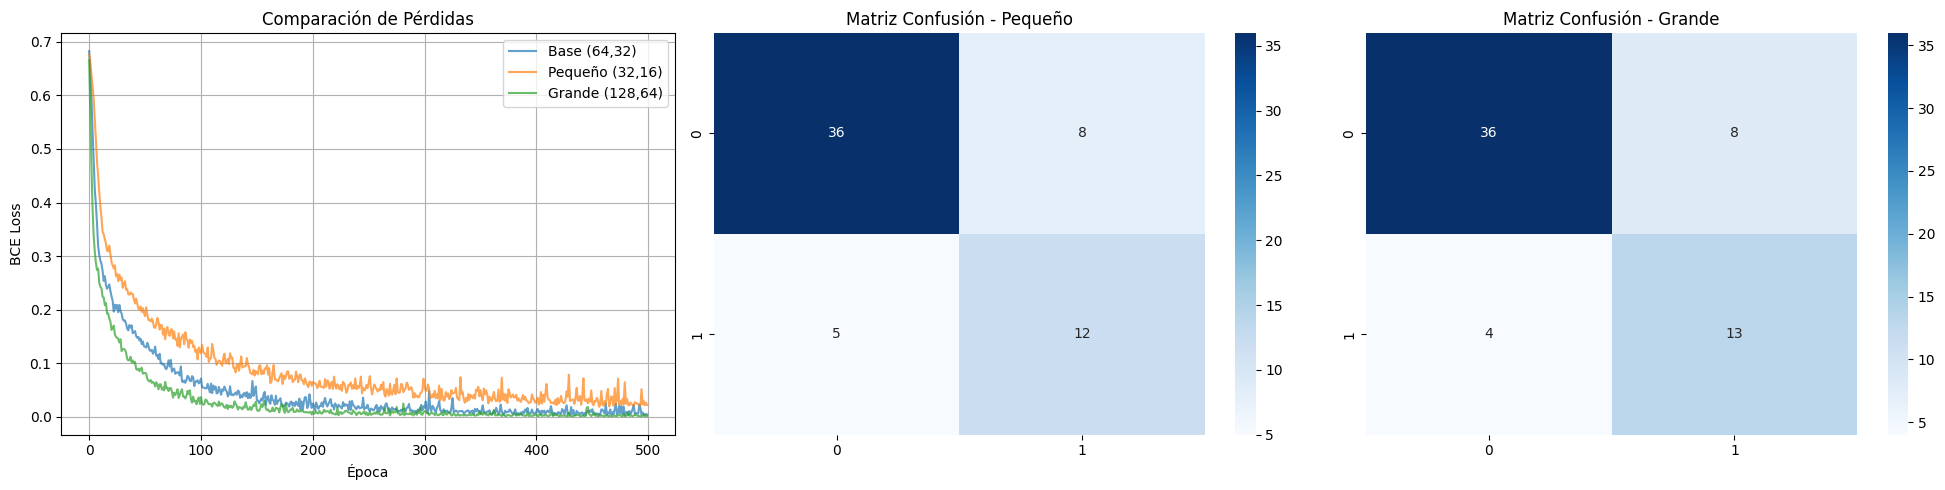

In [159]:
# Evaluar modelos con diferente número de neuronas
acc_small, prec_small, rec_small, f1_small, auc_small, pred_small, _ = evaluate_classifier(model_heart_small, x_test_heart, y_test_heart)
acc_large, prec_large, rec_large, f1_large, auc_large, pred_large, _ = evaluate_classifier(model_heart_large, x_test_heart, y_test_heart)

# Comparación
print("Comparación de modelos por número de neuronas:")
print(f"Modelo Base (64,32)       - Acc: {acc_base:.4f}, F1: {f1_base:.4f}, AUC: {auc_base:.4f}")
print(f"Modelo Pequeño (32,16)    - Acc: {acc_small:.4f}, F1: {f1_small:.4f}, AUC: {auc_small:.4f}")
print(f"Modelo Grande (128,64) - Acc: {acc_large:.4f}, F1: {f1_large:.4f}, AUC: {auc_large:.4f}")

# Visualización comparativa
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Historial de pérdidas
axes[0].plot(loss_history_heart_base, label='Base (64,32)', alpha=0.7)
axes[0].plot(loss_history_small, label='Pequeño (32,16)', alpha=0.7)
axes[0].plot(loss_history_large, label='Grande (128,64)', alpha=0.7)
axes[0].set_title('Comparación de Pérdidas')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('BCE Loss')
axes[0].legend()
axes[0].grid(True)

# Matriz de confusión modelo pequeño
cm_small = confusion_matrix(y_test_heart.numpy(), pred_small)
sns.heatmap(cm_small, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Matriz Confusión - Pequeño')

# Matriz de confusión modelo grande
cm_large = confusion_matrix(y_test_heart.numpy(), pred_large)
sns.heatmap(cm_large, annot=True, fmt='d', cmap='Blues', ax=axes[2])
axes[2].set_title('Matriz Confusión - Grande')

plt.tight_layout()
plt.show()

frente al F1 nos funciona mejor el modelo grande.

## 4. Variación del número de capas

In [160]:
# Modelo con menos capas (1 capa oculta)
class HeartClassifierSingleLayer(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super(HeartClassifierSingleLayer, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.dropout(x)
        x = self.sigmoid(self.output(x))
        return x

# Modelo con más capas (4 capas ocultas)
class HeartClassifierDeepNetwork(nn.Module):
    def __init__(self, input_size):
        super(HeartClassifierDeepNetwork, self).__init__()
        self.hidden1 = nn.Linear(input_size, 128)
        self.hidden2 = nn.Linear(128, 64)
        self.hidden3 = nn.Linear(64, 32)
        self.hidden4 = nn.Linear(32, 16)
        self.output = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = self.dropout(self.relu(self.hidden1(x)))
        x = self.dropout(self.relu(self.hidden2(x)))
        x = self.dropout(self.relu(self.hidden3(x)))
        x = self.dropout(self.relu(self.hidden4(x)))
        x = self.sigmoid(self.output(x))
        return x

# Crear y entrenar modelos
model_single_layer = HeartClassifierSingleLayer(input_size, hidden_size=64)
model_deep = HeartClassifierDeepNetwork(input_size)

print("Modelo con 1 capa oculta:")
print(f"Parámetros: {sum(p.numel() for p in model_single_layer.parameters())}")

print("\nModelo con 4 capas ocultas:")
print(f"Parámetros: {sum(p.numel() for p in model_deep.parameters())}")

# Entrenar modelos
print("\nEntrenando modelo con 1 capa...")
loss_history_single = train_classifier(model_single_layer, x_train_heart, y_train_heart, epochs=500, lr=0.001)

print("\nEntrenando modelo con 4 capas...")
loss_history_deep = train_classifier(model_deep, x_train_heart, y_train_heart, epochs=500, lr=0.001)

Modelo con 1 capa oculta:
Parámetros: 961

Modelo con 4 capas ocultas:
Parámetros: 12673

Entrenando modelo con 1 capa...
Época 100/500, Pérdida: 0.1535
Época 200/500, Pérdida: 0.0868
Época 300/500, Pérdida: 0.0644
Época 400/500, Pérdida: 0.0354
Época 500/500, Pérdida: 0.0289

Entrenando modelo con 4 capas...
Época 100/500, Pérdida: 0.0147
Época 200/500, Pérdida: 0.0033
Época 300/500, Pérdida: 0.0146
Época 400/500, Pérdida: 0.0016
Época 500/500, Pérdida: 0.0009


Comparación de modelos por número de capas:
Modelo Base (2 capas)     - Acc: 0.7869, F1: 0.6486, AUC: 0.8556
Modelo Simple (1 capa)    - Acc: 0.7705, F1: 0.6316, AUC: 0.8516
Modelo Profundo (4 capas) - Acc: 0.7869, F1: 0.6486, AUC: 0.8449


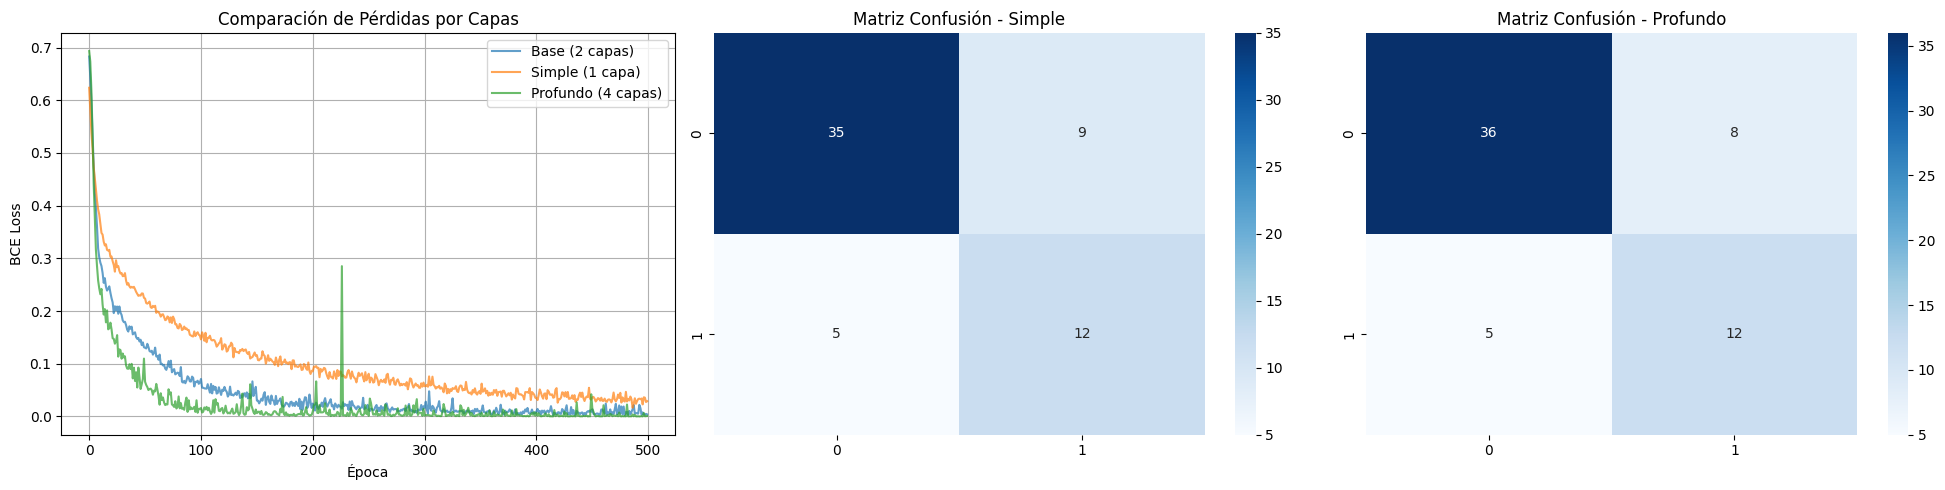

In [161]:
# Evaluar modelos con diferente número de capas
acc_single, prec_single, rec_single, f1_single, auc_single, pred_single, _ = evaluate_classifier(model_single_layer, x_test_heart, y_test_heart)
acc_deep, prec_deep, rec_deep, f1_deep, auc_deep, pred_deep, _ = evaluate_classifier(model_deep, x_test_heart, y_test_heart)

# Comparación
print("Comparación de modelos por número de capas:")
print(f"Modelo Base (2 capas)     - Acc: {acc_base:.4f}, F1: {f1_base:.4f}, AUC: {auc_base:.4f}")
print(f"Modelo Simple (1 capa)    - Acc: {acc_single:.4f}, F1: {f1_single:.4f}, AUC: {auc_single:.4f}")
print(f"Modelo Profundo (4 capas) - Acc: {acc_deep:.4f}, F1: {f1_deep:.4f}, AUC: {auc_deep:.4f}")

# Visualización comparativa
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Historial de pérdidas
axes[0].plot(loss_history_heart_base, label='Base (2 capas)', alpha=0.7)
axes[0].plot(loss_history_single, label='Simple (1 capa)', alpha=0.7)
axes[0].plot(loss_history_deep, label='Profundo (4 capas)', alpha=0.7)
axes[0].set_title('Comparación de Pérdidas por Capas')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('BCE Loss')
axes[0].legend()
axes[0].grid(True)

# Matriz de confusión modelo simple
cm_single = confusion_matrix(y_test_heart.numpy(), pred_single)
sns.heatmap(cm_single, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Matriz Confusión - Simple')

# Matriz de confusión modelo profundo
cm_deep = confusion_matrix(y_test_heart.numpy(), pred_deep)
sns.heatmap(cm_deep, annot=True, fmt='d', cmap='Blues', ax=axes[2])
axes[2].set_title('Matriz Confusión - Profundo')

plt.tight_layout()
plt.show()

Utilizando como metrica el F1 obtenemos mejores resultados con el modelo base y con el profundo. Escogiendo mejor el base, para manejar simplicidad y disminuir costo computacional.

## 5. Variación de funciones de activación

In [162]:
# Modelo con función de activación Tanh
class HeartClassifierTanh(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super(HeartClassifierTanh, self).__init__()
        self.hidden1 = nn.Linear(input_size, hidden_size)
        self.hidden2 = nn.Linear(hidden_size, 32)
        self.output = nn.Linear(32, 1)
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = self.tanh(self.hidden1(x))
        x = self.dropout(x)
        x = self.tanh(self.hidden2(x))
        x = self.dropout(x)
        x = self.sigmoid(self.output(x))
        return x

# Modelo con función de activación LeakyReLU
class HeartClassifierLeakyReLU(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super(HeartClassifierLeakyReLU, self).__init__()
        self.hidden1 = nn.Linear(input_size, hidden_size)
        self.hidden2 = nn.Linear(hidden_size, 32)
        self.output = nn.Linear(32, 1)
        self.leaky_relu = nn.LeakyReLU(0.1)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = self.leaky_relu(self.hidden1(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.hidden2(x))
        x = self.dropout(x)
        x = self.sigmoid(self.output(x))
        return x

# Crear y entrenar modelos
model_tanh = HeartClassifierTanh(input_size, hidden_size=64)
model_leaky_relu = HeartClassifierLeakyReLU(input_size, hidden_size=64)

print("Modelo con activación Tanh:")
print(f"Parámetros: {sum(p.numel() for p in model_tanh.parameters())}")

print("\nModelo con activación LeakyReLU:")
print(f"Parámetros: {sum(p.numel() for p in model_leaky_relu.parameters())}")

# Entrenar modelos
print("\nEntrenando modelo con Tanh...")
loss_history_tanh = train_classifier(model_tanh, x_train_heart, y_train_heart, epochs=500, lr=0.001)

print("\nEntrenando modelo con LeakyReLU...")
loss_history_leaky = train_classifier(model_leaky_relu, x_train_heart, y_train_heart, epochs=500, lr=0.001)

Modelo con activación Tanh:
Parámetros: 3009

Modelo con activación LeakyReLU:
Parámetros: 3009

Entrenando modelo con Tanh...
Época 100/500, Pérdida: 0.1530
Época 200/500, Pérdida: 0.0875
Época 300/500, Pérdida: 0.0440
Época 400/500, Pérdida: 0.0168
Época 500/500, Pérdida: 0.0114

Entrenando modelo con LeakyReLU...
Época 100/500, Pérdida: 0.0707
Época 200/500, Pérdida: 0.0267
Época 300/500, Pérdida: 0.0189
Época 400/500, Pérdida: 0.0163
Época 500/500, Pérdida: 0.0161


Comparación de modelos por función de activación:
Modelo Base (ReLU)        - Acc: 0.7869, F1: 0.6486, AUC: 0.8556
Modelo Tanh               - Acc: 0.7541, F1: 0.5946, AUC: 0.8556
Modelo LeakyReLU          - Acc: 0.7705, F1: 0.6316, AUC: 0.8516


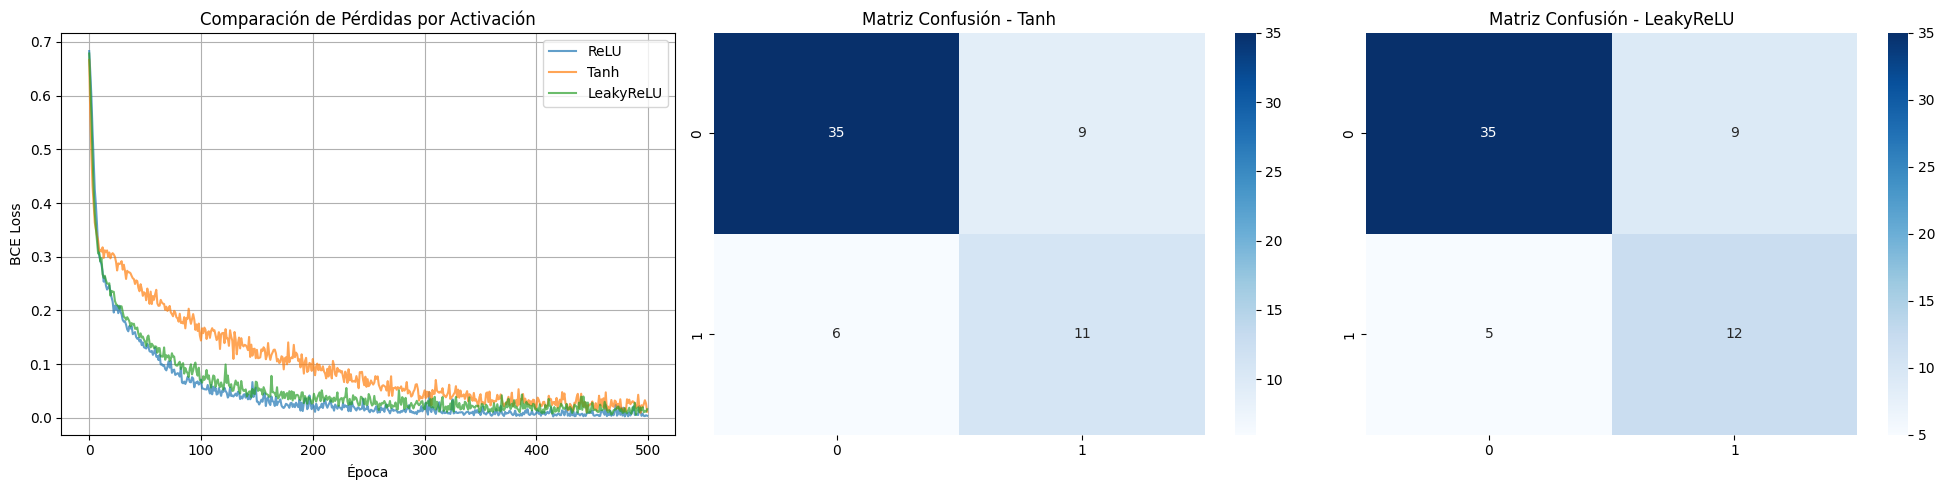

In [163]:
# Evaluar modelos con diferentes funciones de activación
acc_tanh, prec_tanh, rec_tanh, f1_tanh, auc_tanh, pred_tanh, _ = evaluate_classifier(model_tanh, x_test_heart, y_test_heart)
acc_leaky, prec_leaky, rec_leaky, f1_leaky, auc_leaky, pred_leaky, _ = evaluate_classifier(model_leaky_relu, x_test_heart, y_test_heart)

# Comparación
print("Comparación de modelos por función de activación:")
print(f"Modelo Base (ReLU)        - Acc: {acc_base:.4f}, F1: {f1_base:.4f}, AUC: {auc_base:.4f}")
print(f"Modelo Tanh               - Acc: {acc_tanh:.4f}, F1: {f1_tanh:.4f}, AUC: {auc_tanh:.4f}")
print(f"Modelo LeakyReLU          - Acc: {acc_leaky:.4f}, F1: {f1_leaky:.4f}, AUC: {auc_leaky:.4f}")

# Visualización comparativa
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Historial de pérdidas
axes[0].plot(loss_history_heart_base, label='ReLU', alpha=0.7)
axes[0].plot(loss_history_tanh, label='Tanh', alpha=0.7)
axes[0].plot(loss_history_leaky, label='LeakyReLU', alpha=0.7)
axes[0].set_title('Comparación de Pérdidas por Activación')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('BCE Loss')
axes[0].legend()
axes[0].grid(True)

# Matriz de confusión modelo tanh
cm_tanh = confusion_matrix(y_test_heart.numpy(), pred_tanh)
sns.heatmap(cm_tanh, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Matriz Confusión - Tanh')

# Matriz de confusión modelo leaky relu
cm_leaky = confusion_matrix(y_test_heart.numpy(), pred_leaky)
sns.heatmap(cm_leaky, annot=True, fmt='d', cmap='Blues', ax=axes[2])
axes[2].set_title('Matriz Confusión - LeakyReLU')

plt.tight_layout()
plt.show()

## Comparacion de todos los modelos y conclución

Resumen de resultados de todos los modelos:
               Modelo  Accuracy  Precision  Recall  F1-Score     AUC  \
0  Base (ReLU, 64-32)    0.7869     0.6000  0.7059    0.6486  0.8556   
1     Pequeño (32-16)    0.7869     0.6000  0.7059    0.6486  0.8690   
2     Grande (128-64)    0.8033     0.6190  0.7647    0.6842  0.8476   
3     Simple (1 capa)    0.7705     0.5714  0.7059    0.6316  0.8516   
4  Profundo (4 capas)    0.7869     0.6000  0.7059    0.6486  0.8449   
5                Tanh    0.7541     0.5500  0.6471    0.5946  0.8556   
6           LeakyReLU    0.7705     0.5714  0.7059    0.6316  0.8516   

   Parámetros  
0        3009  
1         993  
2       10113  
3         961  
4       12673  
5        3009  
6        3009  


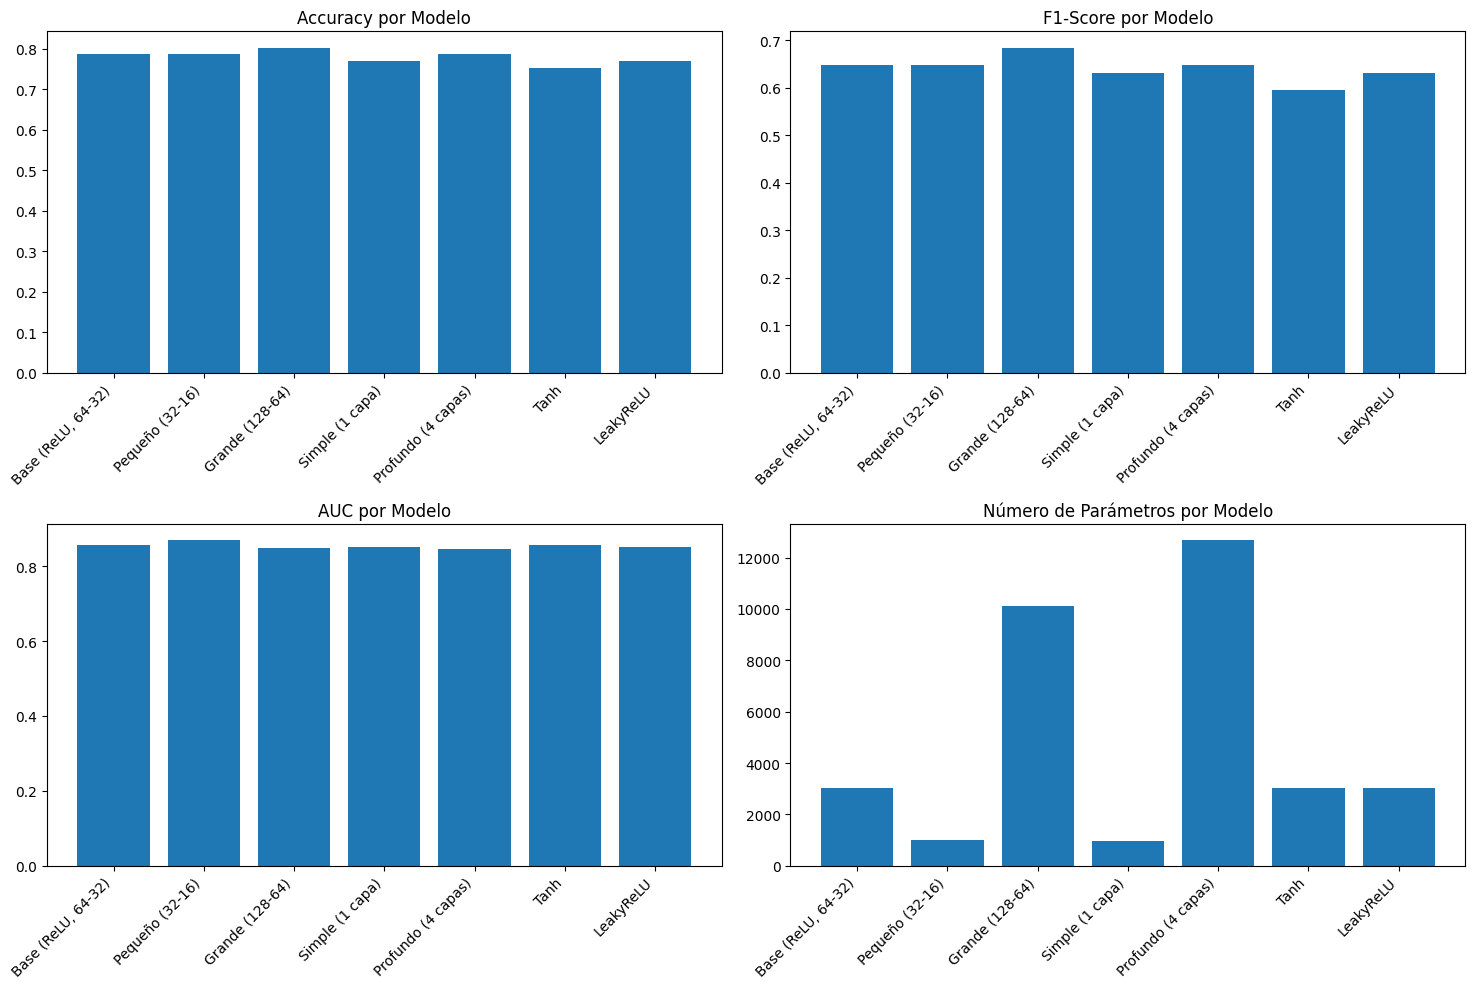

In [164]:
# Crear tabla resumen de todos los modelos
import pandas as pd

results_data = {
    'Modelo': ['Base (ReLU, 64-32)', 'Pequeño (32-16)', 'Grande (128-64)', 
               'Simple (1 capa)', 'Profundo (4 capas)', 'Tanh', 'LeakyReLU'],
    'Accuracy': [acc_base, acc_small, acc_large, acc_single, acc_deep, acc_tanh, acc_leaky],
    'Precision': [prec_base, prec_small, prec_large, prec_single, prec_deep, prec_tanh, prec_leaky],
    'Recall': [rec_base, rec_small, rec_large, rec_single, rec_deep, rec_tanh, rec_leaky],
    'F1-Score': [f1_base, f1_small, f1_large, f1_single, f1_deep, f1_tanh, f1_leaky],
    'AUC': [auc_base, auc_small, auc_large, auc_single, auc_deep, auc_tanh, auc_leaky],
    'Parámetros': [
        sum(p.numel() for p in model_heart_base.parameters()),
        sum(p.numel() for p in model_heart_small.parameters()),
        sum(p.numel() for p in model_heart_large.parameters()),
        sum(p.numel() for p in model_single_layer.parameters()),
        sum(p.numel() for p in model_deep.parameters()),
        sum(p.numel() for p in model_tanh.parameters()),
        sum(p.numel() for p in model_leaky_relu.parameters())
    ]
}

results_df = pd.DataFrame(results_data)
print("Resumen de resultados de todos los modelos:")
print(results_df.round(4))

# Visualización del resumen
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Accuracy
axes[0,0].bar(range(len(results_df)), results_df['Accuracy'])
axes[0,0].set_title('Accuracy por Modelo')
axes[0,0].set_xticks(range(len(results_df)))
axes[0,0].set_xticklabels(results_df['Modelo'], rotation=45, ha='right')

# F1-Score
axes[0,1].bar(range(len(results_df)), results_df['F1-Score'])
axes[0,1].set_title('F1-Score por Modelo')
axes[0,1].set_xticks(range(len(results_df)))
axes[0,1].set_xticklabels(results_df['Modelo'], rotation=45, ha='right')

# AUC
axes[1,0].bar(range(len(results_df)), results_df['AUC'])
axes[1,0].set_title('AUC por Modelo')
axes[1,0].set_xticks(range(len(results_df)))
axes[1,0].set_xticklabels(results_df['Modelo'], rotation=45, ha='right')

# Número de parámetros
axes[1,1].bar(range(len(results_df)), results_df['Parámetros'])
axes[1,1].set_title('Número de Parámetros por Modelo')
axes[1,1].set_xticks(range(len(results_df)))
axes[1,1].set_xticklabels(results_df['Modelo'], rotation=45, ha='right')

plt.tight_layout()
plt.show()

Se observa que es mejor el modelo 
2     Grande (128-64)    0.8033     0.6190  0.7647    0.6842  0.8476   
Seguido del pequeño dada su simplisidad.
1     Pequeño (32-16)    0.7869     0.6000  0.7059    0.6486  0.8690   
